<a href="https://colab.research.google.com/github/andrewkang12345/monotonic-nn-nfl/blob/main/Monotonic_Neural_Networks_to_visualize_NFL_Pitch_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Pitch Control

# Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for mpl animation
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
from scipy.stats import multivariate_normal as mvn


In [ ]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get -qq update
!apt install -y -qq imagemagick

The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw

In [ ]:
DATADIR = '/content/drive/My Drive/nfl_data_bowl/nfl-big-data-bowl-2024_unzipped/'

tackles = pd.read_csv(DATADIR + 'tackles.csv')
players = pd.read_csv(DATADIR + 'players.csv')
plays = pd.read_csv(DATADIR + 'plays.csv')
games = pd.read_csv(DATADIR + 'games.csv')

tracking_week_1 = pd.read_csv(DATADIR + '/tracking_week_1.csv')
tracking_week_2 = pd.read_csv(DATADIR + '/tracking_week_2.csv') # Used for animated validation
tracking_week_3 = pd.read_csv(DATADIR + '/tracking_week_3.csv')
tracking_week_4 = pd.read_csv(DATADIR + '/tracking_week_4.csv')
tracking_week_5 = pd.read_csv(DATADIR + '/tracking_week_5.csv')
tracking_week_6 = pd.read_csv(DATADIR + '/tracking_week_6.csv')
tracking_week_7 = pd.read_csv(DATADIR + '/tracking_week_7.csv')
tracking_week_8 = pd.read_csv(DATADIR + '/tracking_week_8.csv')
tracking_week_9 = pd.read_csv(DATADIR + '/tracking_week_9.csv')


In [ ]:
def model_influence_function(model, scaler, defensive_player_data, carrier_grid_x, carrier_grid_y):

    # Flatten the grid matrices and stack them as columns
    carrier_grid_points = np.column_stack([carrier_grid_x.ravel(), carrier_grid_y.ravel()])

    # Replicate player data to match the number of grid points
    replicated_defensive_player_data = pd.DataFrame(np.tile(defensive_player_data.to_numpy(), (len(carrier_grid_points), 1)),
                                          columns=defensive_player_data.columns)

    replicated_defensive_player_data['carrier_x'] = replicated_defensive_player_data['carrier_x'].astype(float)
    replicated_defensive_player_data['carrier_y'] = replicated_defensive_player_data['carrier_y'].astype(float)

    # Update the 'relative_x', 'relative_y', and 'distance' columns based on grid points
    # replicated_defensive_player_data['relative_x'] = carrier_grid_points[:, 0] - replicated_defensive_player_data['carrier_x'].to_numpy()
    # replicated_defensive_player_data['relative_y'] = carrier_grid_points[:, 1] - replicated_defensive_player_data['carrier_y'].to_numpy()
    replicated_defensive_player_data['relative_x'] = carrier_grid_points[:, 0] - replicated_defensive_player_data['x'].to_numpy()
    replicated_defensive_player_data['relative_y'] = carrier_grid_points[:, 1] - replicated_defensive_player_data['y'].to_numpy()

    # Calculate the distance using the updated 'relative_x' and 'relative_y' columns
    replicated_defensive_player_data['distance'] = np.sqrt((replicated_defensive_player_data['relative_x']**2 + replicated_defensive_player_data['relative_y']**2).astype(float))

    # Convert speed and direction to velocity components in Cartesian coordinates
    defender_velocity_x = replicated_defensive_player_data['s'] * np.cos(np.deg2rad(replicated_defensive_player_data['dir'].astype(float)))
    defender_velocity_y = replicated_defensive_player_data['s'] * np.sin(np.deg2rad(replicated_defensive_player_data['dir'].astype(float)))
    carrier_velocity_x = replicated_defensive_player_data['carrier_s'] * np.cos(np.deg2rad(replicated_defensive_player_data['carrier_dir'].astype(float)))
    carrier_velocity_y = replicated_defensive_player_data['carrier_s'] * np.sin(np.deg2rad(replicated_defensive_player_data['carrier_dir'].astype(float)))

    # Calculate relative velocity components
    replicated_defensive_player_data['rel_velocity_x'] = carrier_velocity_x - defender_velocity_x
    replicated_defensive_player_data['rel_velocity_y'] = carrier_velocity_y - defender_velocity_y

    # Calculate relative speed (magnitude of the relative velocity vector)
    replicated_defensive_player_data['rel_speed'] = np.sqrt((replicated_defensive_player_data['rel_velocity_x']**2 + replicated_defensive_player_data['rel_velocity_y']**2).astype(float))

    # Calculate defender and carrier velocity magnitudes
    replicated_defensive_player_data['defender_velocity_magnitude'] = np.sqrt((defender_velocity_x**2 + defender_velocity_y**2).astype(float))
    replicated_defensive_player_data['carrier_velocity_magnitude'] = np.sqrt((carrier_velocity_x**2 + carrier_velocity_y**2).astype(float))

    # Calculate the direction vector from the defender to the ball carrier
    direction_vector_x = replicated_defensive_player_data['carrier_x'] - replicated_defensive_player_data['x']
    direction_vector_y = replicated_defensive_player_data['carrier_y'] - replicated_defensive_player_data['y']

    # Calculate the direction vector magnitude
    direction_vector_magnitude = np.sqrt((direction_vector_x**2 + direction_vector_y**2).astype(float))

    # Check if magnitude is zero to avoid division by zero
    if direction_vector_magnitude.iloc[0] == 0:
        direction_vector_x_normalized = 0
        direction_vector_y_normalized = 0
    else:
        # Normalize the direction vector
        direction_vector_x_normalized = direction_vector_x / direction_vector_magnitude
        direction_vector_y_normalized = direction_vector_y / direction_vector_magnitude

    # Calculate the defender's velocity vector magnitude
    defender_velocity_magnitude = np.sqrt((defender_velocity_x**2 + defender_velocity_y**2).astype(float))

    # Check if magnitude is zero to avoid division by zero
    if defender_velocity_magnitude.iloc[0] == 0:
        defender_velocity_x_normalized = 0
        defender_velocity_y_normalized = 0
    else:
        # Normalize the defender's velocity vector
        defender_velocity_x_normalized = defender_velocity_x / defender_velocity_magnitude
        defender_velocity_y_normalized = defender_velocity_y / defender_velocity_magnitude

    default_value = 0
    replicated_defensive_player_data['cosine_similarity'] = np.where(
        (defender_velocity_magnitude != 0) & (direction_vector_magnitude != 0),
        (direction_vector_x_normalized * defender_velocity_x_normalized +
        direction_vector_y_normalized * defender_velocity_y_normalized),
        default_value
    )

    # Scale the features
    scaled_features = scaler.transform(replicated_defensive_player_data[['distance', 'rel_speed', 'defender_velocity_magnitude',
                                                               'carrier_velocity_magnitude', 'relative_x', 'relative_y',
                                                               'cosine_similarity']])

    # Predict using the model
    with torch.no_grad():
        logits = model(torch.tensor(scaled_features, dtype=torch.float32))
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = probabilities[:, 1].numpy()  # Assuming binary classification

    # Reshape predictions to match grid shape
    predictions = predictions.reshape(carrier_grid_x.shape)

    return predictions





def get_play_by_frame(fid, ax, los, one_play):
    ax.cla()
    gid = one_play['gameId'].unique()[0]
    pid = one_play['playId'].unique()[0]
    play_info = plays.loc[(plays['gameId'] == gid) & (plays['playId'] == pid)]
    one_frame = one_play.loc[one_play['frameId'] == fid]

    # Define the grid for contour
    x = np.linspace(-10, 110, 500)
    y = np.linspace(0, 54, 500)
    X, Y = np.meshgrid(x, y)
    locations = np.dstack((X, Y))

    # Sum the influences of all players
    total_influence = np.zeros_like(X)
    for index, player in one_frame.iterrows():

        # if player['club'] == play_info['defensiveTeam'].iloc[0] and int(player['nflId']) % 5 == 0:

        if player['club'] == play_info['defensiveTeam'].iloc[0]:

            ball_carrier_df = one_frame.loc[(one_frame['nflId'] == play_info['ballCarrierId'].values[0]) \
                             & (one_frame['frameId'] == player['frameId'])]

            defensive_player_data = pd.concat([player[['x', 'y', 's', 'dir']].to_frame().T.reset_index(drop=True), \
                                     ball_carrier_df[['x', 'y', 's', 'dir']].rename(columns={'x': 'carrier_x', 'y': 'carrier_y', 's': 'carrier_s', 'dir': 'carrier_dir'})\
                                     .reset_index(drop=True)], axis=1)


            # Calculate the distance
            defensive_player_data['distance'] = np.sqrt(((defensive_player_data['x'] - defensive_player_data['carrier_x'])**2 +
                                              (defensive_player_data['y'] - defensive_player_data['carrier_y'])**2).values[0])

            # Convert speed and direction to velocity components
            player_velocity_x = defensive_player_data['s'] * np.cos(np.deg2rad(defensive_player_data['dir'].values[0]))
            player_velocity_y = defensive_player_data['s'] * np.sin(np.deg2rad(defensive_player_data['dir'].values[0]))
            ball_carrier_velocity_x = defensive_player_data['carrier_s'].values[0] * np.cos(np.deg2rad(defensive_player_data['carrier_dir'].values[0]))
            ball_carrier_velocity_y = defensive_player_data['carrier_s'].values[0] * np.sin(np.deg2rad(defensive_player_data['carrier_dir'].values[0]))

            # Calculate relative velocity components
            rel_velocity_x = ball_carrier_velocity_x - player_velocity_x
            rel_velocity_y = ball_carrier_velocity_y - player_velocity_y

            # Calculate relative speed and direction
            defensive_player_data['rel_speed'] = np.sqrt((rel_velocity_x**2 + rel_velocity_y**2).values[0])
            defensive_player_data['rel_dir'] = np.rad2deg(np.arctan2(rel_velocity_y.values[0], rel_velocity_x.values[0])) % 360

            # Add to total influence map
            influence = model_influence_function(model, scaler, defensive_player_data, X, Y)
            # influence = model_influence_function(defensive_player_data, X, Y)
            total_influence += influence

    # Plot the total influence as a contour
    ax.contourf(X, Y, total_influence, levels=15, alpha=0.5, cmap='coolwarm')

# FIX THIS PART!!!!
    # Display the influence number in the corner
    # ax.text(0.05, 0.05, f'Tackle Probability: {total_influence:.2f}',
    #        transform=ax.transAxes, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    # Create a scatter plot
    sns.scatterplot(x='x', y='y', data=one_frame, hue='club', ax=ax, s=100)

    # Additional plot settings
    ax.axvline(los, c='k', ls=':')
    ax.axvline(0, c='k', ls='-')
    ax.axvline(100, c='k', ls='-')
    ax.set_title(f"game {gid} play {pid}")
    ax.legend([]).set_visible(False)
    sns.despine(left=True)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xlim(-10, 110)
    ax.set_ylim(0, 54)

    return ax




def animate_play(one_play):
  """
  animate a given NFL play from the BDB

  inputs:
    one_play: one play from the BDB data. you will want to
      filter your dataset using gameId and playId.

  output:
    animated gif, saved to your current working directory

  """
  # get game and play IDs
  gid = one_play['gameId'].unique()[0]
  pid = one_play['playId'].unique()[0]

  # get line of scrimmage info from the football X location from the  first frame of data
  los = one_play.loc[(one_play['frameId']==1) & (one_play['club']=='football'), 'x'].values[0]

  # set figure size; this is hard coded but seemed to work well
  fig = plt.figure(figsize=(14.4, 6.4))

  # get current axis of the figure
  ax = fig.gca()

  # matplotlib animate function
  # relies on get_play_by_frame()
  # `interval = 100` is something like frames per second i think
  # repeat=True is to have the animation continuously repeat
  ani = animation.FuncAnimation(fig, get_play_by_frame, \
                                frames=one_play['frameId'].unique().shape[0], \
                                interval=100, repeat=True, \
                                fargs=(ax,los,one_play,))


  # saving to m4 using ffmpeg writer
  writervideo = animation.FFMpegWriter(fps=10)
  ani.save('realPC1.mp4', writer=writervideo)


  # close the matplotlib figure when done (if you're batch processing gifs, this allows you to end one gif and begin another gif of a play)
  plt.close()


  return ani

# Area of Influence
- Each player's personalized normal distribution contours of likely areas of tackles (like pitch control)
- Each player's personalized normal distribution contours of likely areas of interceptions/blocks (like pitch control)

## Part 1: Pre-model Work
- given runner, defender, relative velocity (x and y), relative distance
- Use both gameId and playId to track a specific play.
- How should we label tackles? -> just the last few frames before actual tackle?


In [ ]:
tracking_week_1 = pd.concat([tracking_week_1, tracking_week_3, tracking_week_4], ignore_index=True)

In [ ]:
tracking_plays_week_1 = pd.merge(pd.merge(tracking_week_1, plays, how='outer', on=['gameId', 'playId']), tackles, how='outer', on=['gameId', 'nflId', 'playId'])
tackle_ind_df = tracking_plays_week_1.loc[tracking_plays_week_1['club'] == tracking_plays_week_1['defensiveTeam']][['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'x', 'y', 's', 'dir', 'tackle']]
max_frame_id = tackle_ind_df.groupby(['gameId', 'playId'])['frameId'].max()
tackle_ind_df = tackle_ind_df[tackle_ind_df['frameId'] <= tackle_ind_df.groupby(['gameId', 'playId'])['frameId'].transform(lambda x: max_frame_id.loc[x.name[0], x.name[1]] - 5)]

def is_last_10_frames(row):
    return row['frameId'] > max_frame_id.loc[row['gameId'], row['playId']] - 10

tackle_ind_df['is_last_10_frames'] = tackle_ind_df.apply(is_last_10_frames, axis=1)
tackle_ind_df.loc[(tackle_ind_df['tackle'] == 1) & (~tackle_ind_df['is_last_10_frames']), 'tackle'] = 0
tackle_ind_df.drop('is_last_10_frames', axis=1, inplace=True)
tackle_ind_df['tackle'].fillna(0, inplace=True)

carrier_coords = tracking_plays_week_1[tracking_plays_week_1['nflId'] == tracking_plays_week_1['ballCarrierId']][['gameId', 'playId', 'frameId', 'x', 'y', 's', 'dir']]
carrier_coords.rename(columns={'x': 'carrier_x', 'y': 'carrier_y', 's': 'carrier_s', 'dir': 'carrier_dir'}, inplace=True)

final_df = pd.merge(tackle_ind_df, carrier_coords, on=['gameId', 'playId', 'frameId'], how='left')

# Calculating Euclidean distance
final_df['distance'] = np.sqrt((final_df['carrier_x'] - final_df['x'])**2 + (final_df['carrier_y'] - final_df['y'])**2)

# Convert speed and direction to velocity components in Cartesian coordinates
defender_velocity_x = final_df['s'] * np.cos(np.deg2rad(final_df['dir']))
defender_velocity_y = final_df['s'] * np.sin(np.deg2rad(final_df['dir']))
carrier_velocity_x = final_df['carrier_s'] * np.cos(np.deg2rad(final_df['carrier_dir']))
carrier_velocity_y = final_df['carrier_s'] * np.sin(np.deg2rad(final_df['carrier_dir']))

# Calculating relative velocity components
final_df['rel_velocity_x'] = carrier_velocity_x - defender_velocity_x
final_df['rel_velocity_y'] = carrier_velocity_y - defender_velocity_y

# Calculating relative speed (magnitude of the relative velocity vector)
final_df['rel_speed'] = np.sqrt(final_df['rel_velocity_x']**2 + final_df['rel_velocity_y']**2)

# Calculating relative direction (angle of the relative velocity vector)
final_df['rel_dir'] = np.rad2deg(np.arctan2(final_df['rel_velocity_y'], final_df['rel_velocity_x']))

# Adjusting the angle to be between 0 and 360 degrees
final_df['rel_dir'] = final_df['rel_dir'] % 360

# Calculating defender and carrier velocity magnitudes
final_df['defender_velocity_magnitude'] = np.sqrt(defender_velocity_x**2 + defender_velocity_y**2)
final_df['carrier_velocity_magnitude'] = np.sqrt(carrier_velocity_x**2 + carrier_velocity_y**2)

# Calculating relative position
final_df['relative_x'] = final_df['carrier_x'] - final_df['x']
final_df['relative_y'] = final_df['carrier_y'] - final_df['y']

# Calculate the direction vector from the defender to the ball carrier
direction_vector_x = final_df['carrier_x'] - final_df['x']
direction_vector_y = final_df['carrier_y'] - final_df['y']

# Normalize the direction vector
direction_vector_magnitude = np.sqrt(direction_vector_x**2 + direction_vector_y**2)
direction_vector_x_normalized = direction_vector_x / direction_vector_magnitude
direction_vector_y_normalized = direction_vector_y / direction_vector_magnitude

# Normalize the defender's velocity vector
defender_velocity_magnitude = np.sqrt(defender_velocity_x**2 + defender_velocity_y**2)
defender_velocity_x_normalized = defender_velocity_x / defender_velocity_magnitude
defender_velocity_y_normalized = defender_velocity_y / defender_velocity_magnitude

# Calculate the cosine similarity
default_value = 0
final_df['cosine_similarity'] = np.where(
    (defender_velocity_magnitude != 0) & (direction_vector_magnitude != 0),
    (direction_vector_x_normalized * defender_velocity_x_normalized +
     direction_vector_y_normalized * defender_velocity_y_normalized),
    default_value
)

# Select only the desired features
final_df = final_df[['distance', 'rel_speed', 'defender_velocity_magnitude',
                     'carrier_velocity_magnitude', 'relative_x', 'relative_y', 'cosine_similarity', 'tackle']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Very imbalanced data!
tackle_ind_df['tackle'].value_counts()

tackle
0.0    1770216
1.0      17515
Name: count, dtype: int64

In [ ]:
(1251833-98406)/1251833 # proportion of non-tackles

0.9213904730103776

## Monotonic Neural Network Training & Eval

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

scaler = StandardScaler()
X = final_df[['distance', 'rel_speed', 'defender_velocity_magnitude',
              'carrier_velocity_magnitude', 'relative_x', 'relative_y', 'cosine_similarity']].values
y = final_df['tackle'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_df = pd.DataFrame(np.column_stack((X_train, y_train)), columns=final_df.columns[:-1].tolist() + ['tackle'])
train_tackle_rows = train_df[train_df['tackle'] == 1]
train_duplicated_tackle_rows = pd.concat([train_tackle_rows] * 100, ignore_index=True)
train_df = pd.concat([train_df, train_duplicated_tackle_rows], ignore_index=True)

X_train_scaled = scaler.fit_transform(train_df.iloc[:, :-1].values)
X_test_scaled = scaler.transform(X_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(train_df['tackle'].values, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

class MonotonicLayer(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        return F.linear(x, torch.abs(self.weight), self.bias)

class MonotonicNeuralNet(nn.Module):
    def __init__(self, input_size):
        super(MonotonicNeuralNet, self).__init__()
        self.fc1 = MonotonicLayer(input_size, 50)
        self.fc2 = MonotonicLayer(50, 10)
        self.fc3 = nn.Linear(10, 2)  # 2 output nodes for binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MonotonicNeuralNet(X_train.shape[1])

class_counts = np.bincount(y_train.long().numpy())
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

train_probs = []
val_probs = []

for epoch in range(10):  # Number of epochs
    print(f"Epoch: {epoch}")
    model.train()  # Set the model to training mode
    total_train_prob = 0
    num_train_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

        probs = F.softmax(output, dim=1)
        correct_class_probs = probs[range(len(target)), target.long()]
        total_train_prob += correct_class_probs.mean().item()
        num_train_batches += 1


    avg_train_prob = total_train_prob / num_train_batches
    train_probs.append(avg_train_prob)  # Store average training probability

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(X_test)
        probs = F.softmax(output, dim=1)
        correct_class_probs = probs[range(len(y_test)), y_test.long()]
        avg_val_prob = correct_class_probs.mean().item()
        val_probs.append(avg_val_prob)  # Store average validation probability


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


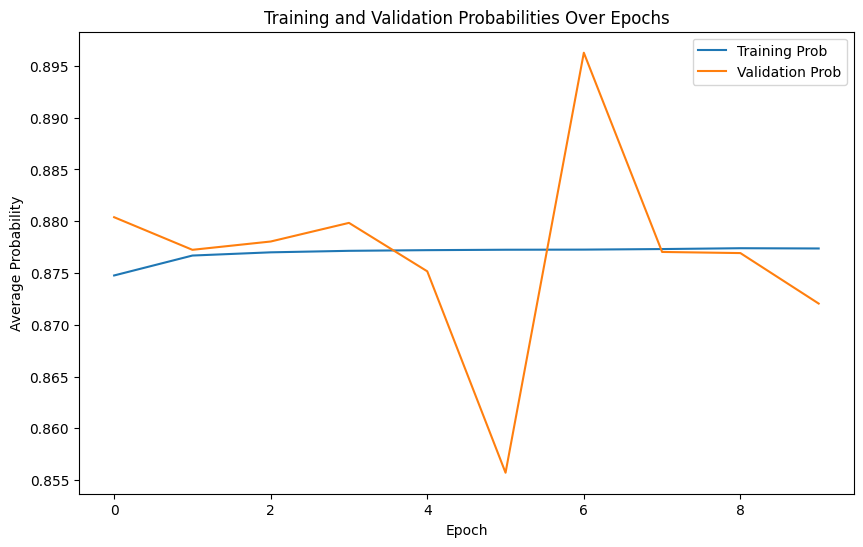

In [ ]:
# Plot the training and validation probabilities
plt.figure(figsize=(10, 6))
plt.plot(train_probs, label='Training Prob')
plt.plot(val_probs, label='Validation Prob')
plt.xlabel('Epoch')
plt.ylabel('Average Probability')
plt.title('Training and Validation Probabilities Over Epochs')
plt.legend()
plt.show()



# calibration threshold

## Videos

In [ ]:
gameId = 2022091800
playId = 1108

play = tracking_week_2.loc[(tracking_week_2['gameId']==gameId) & (tracking_week_2['playId']==playId)]
animate_play(play)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

<Figure size 640x480 with 0 Axes>

In [ ]:
def animate_play(one_play):
  """
  animate a given NFL play from the BDB

  inputs:
    one_play: one play from the BDB data. you will want to
      filter your dataset using gameId and playId.

  output:
    animated gif, saved to your current working directory

  """
  # get game and play IDs
  gid = one_play['gameId'].unique()[0]
  pid = one_play['playId'].unique()[0]

  # get line of scrimmage info from the football X location from the  first frame of data
  los = one_play.loc[(one_play['frameId']==1) & (one_play['club']=='football'), 'x'].values[0]

  # set figure size; this is hard coded but seemed to work well
  fig = plt.figure(figsize=(14.4, 6.4))

  # get current axis of the figure
  ax = fig.gca()

  # matplotlib animate function
  # relies on get_play_by_frame()
  # `interval = 100` is something like frames per second i think
  # repeat=True is to have the animation continuously repeat
  ani = animation.FuncAnimation(fig, get_play_by_frame, \
                                frames=one_play['frameId'].unique().shape[0], \
                                interval=100, repeat=True, \
                                fargs=(ax,los,one_play,))


  # saving to m4 using ffmpeg writer
  writervideo = animation.FFMpegWriter(fps=10)
  ani.save('realPC2.mp4', writer=writervideo)


  # close the matplotlib figure when done (if you're batch processing gifs, this allows you to end one gif and begin another gif of a play)
  plt.close()

  # save the matplotlib animation as a gif
  # requires imagemagick or some sort of gif renderer
  # this works in google colab if you apt install imagemagick
  # ani.save(f'{gid}_{pid}.gif', writer='imagema/gick', fps=10)

  return ani

In [ ]:
gameId = 2022091800
playId = 253

play = tracking_week_2.loc[(tracking_week_2['gameId']==gameId) & (tracking_week_2['playId']==playId)]
animate_play(play)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

<Figure size 640x480 with 0 Axes>

In [ ]:
def animate_play(one_play):
  """
  animate a given NFL play from the BDB

  inputs:
    one_play: one play from the BDB data. you will want to
      filter your dataset using gameId and playId.

  output:
    animated gif, saved to your current working directory

  """
  # get game and play IDs
  gid = one_play['gameId'].unique()[0]
  pid = one_play['playId'].unique()[0]

  # get line of scrimmage info from the football X location from the  first frame of data
  los = one_play.loc[(one_play['frameId']==1) & (one_play['club']=='football'), 'x'].values[0]

  # set figure size; this is hard coded but seemed to work well
  fig = plt.figure(figsize=(14.4, 6.4))

  # get current axis of the figure
  ax = fig.gca()

  # matplotlib animate function
  # relies on get_play_by_frame()
  # `interval = 100` is something like frames per second i think
  # repeat=True is to have the animation continuously repeat
  ani = animation.FuncAnimation(fig, get_play_by_frame, \
                                frames=one_play['frameId'].unique().shape[0], \
                                interval=100, repeat=True, \
                                fargs=(ax,los,one_play,))


  # saving to m4 using ffmpeg writer
  writervideo = animation.FFMpegWriter(fps=10)
  ani.save('realPC3.mp4', writer=writervideo)


  # close the matplotlib figure when done (if you're batch processing gifs, this allows you to end one gif and begin another gif of a play)
  plt.close()

  # save the matplotlib animation as a gif
  # requires imagemagick or some sort of gif renderer
  # this works in google colab if you apt install imagemagick
  # ani.save(f'{gid}_{pid}.gif', writer='imagema/gick', fps=10)

  return ani

In [ ]:
gameId = 2022091800
playId = 4081

play = tracking_week_2.loc[(tracking_week_2['gameId']==gameId) & (tracking_week_2['playId']==playId)]
animate_play(play)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

<Figure size 640x480 with 0 Axes>